# Neurog Internship: (Task 8 - Implementation Of Numpy's Vectorized Operations In Order To Make The Backtesting Code Faster. Also, Backtesting On Multiple Technical Indicator Signals)

## All Libraries

In [9]:
# For Vizualization & Plotting
import matplotlib.pyplot as plt

# Technical Analysis Library Modules
from ta.momentum import StochRSIIndicator
from ta.momentum import RSIIndicator
from ta.trend import PSARIndicator
from ta.trend import ADXIndicator

# Other Necessary Libraries
import pandas as pd
import numpy as np
import copy

## All Declarations

In [ ]:
# Define the relative path to the CSV file
csv_filename = "BTCUSDT_1_Minute_From_2020_Till_Now.csv"

# Settig Up The Directory From The Directory Hierarchy
# Get the notebook's current directory
notebook_dir = os.path.dirname(os.path.abspath(__file__))

# Go up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Create the full path to the output CSV file in the 'ohlc' directory within 'data'
data_dir = os.path.join(parent_dir, "data")
ohlc_dir = os.path.join(data_dir, "ohlc")
full_csv_path = os.path.join(ohlc_dir, csv_filename)

## (Function To Convert DF To Any Timeframe) - Taken From The Previous Day

In [30]:
# Functions converts the dataframe into any given time frame.
def convert_1m_to_any_timeframe(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Convert a DataFrame of 1-minute OHLC data to any given timeframe.

    Args:
    - df (pd.DataFrame): DataFrame containing 1-minute OHLC data. 
      The DataFrame should have a datetime index & columns ['Open', 'High', 'Low', 'Close', 'Volume'].
    - timeframe (str): The desired timeframe to resample the data to (e.g., '1H' for 1 hour, '1D' for 1 day).

    Returns:
    - pd.DataFrame: Resampled DataFrame with OHLC data in the specified timeframe. The index will be renamed to
      reflect the new timeframe.

    Example:
    ```
    resampled_df = convert_1m_to_any_timeframe(ohlc_df, '1H')
    ```
    """
    # Ensure the DataFrame index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Try resampling the data to the desired timeframe
    try:
        df_resampled = df.resample(timeframe).agg({
            'Open': 'first',  # Take the first 'Open' value in the timeframe
            'High': 'max',    # Take the maximum 'High' value in the timeframe
            'Low': 'min',     # Take the minimum 'Low' value in the timeframe
            'Close': 'last',  # Take the last 'Close' value in the timeframe
            'Volume': 'mean'  # Take the mean 'Volume' value in the timeframe
        })
    except Exception as e:
        print(f"An error occurred while resampling! Error message: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

    # Rename the index to reflect the new timeframe
    df_resampled.index.rename(f'Open time ({timeframe})', inplace = True)
    
    return df_resampled

## MACD Indicator Function

In [31]:
def calculate_macd(df: pd.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> pd.DataFrame:
    """
    Calculate the MACD (Moving Average Convergence Divergence) for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - short_window (int): The window size for the short-term EMA, default is 12.
    - long_window (int): The window size for the long-term EMA, default is 26.
    - signal_window (int): The window size for the Signal line, default is 9.

    Returns:
    - pd.DataFrame: DataFrame with the MACD line and Signal line.
    """
    # Calculate the short-term and long-term EMAs
    df['EMA_12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    return df

def generate_macd_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on MACD values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'MACD' and 'Signal_Line' values.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['MACD'] > df['Signal_Line'], 'Signal'] = 1  # Buy signal
    df.loc[df['MACD'] < df['Signal_Line'], 'Signal'] = -1  # Sell signal

    return df

## RSI Indicator Function

In [32]:
def calculate_rsi(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Relative Strength Index (RSI) using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.

    Returns:
    - pd.DataFrame: DataFrame with the RSI values.
    """
    # Calculate RSI using ta library
    rsi_indicator = RSIIndicator(close=df['Close'], window=window, fillna=True)
    df['RSI'] = rsi_indicator.rsi()

    return df

def generate_rsi_signals(df: pd.DataFrame, rsi_lower: int = 10, rsi_upper: int = 90) -> pd.DataFrame:
    """
    Generate trading signals based on RSI values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'RSI' values.
    - rsi_lower (int): RSI lower threshold for buy signals, default is 30.
    - rsi_upper (int): RSI upper threshold for sell signals, default is 70.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['RSI'] > rsi_upper, 'Signal'] = -1  # Sell signal
    df.loc[df['RSI'] < rsi_lower, 'Signal'] = 1   # Buy signal

    return df

## Stochastic RSI Indicator Function

In [33]:
def calculate_stochrsi(
    df: pd.DataFrame,
    window: int = 14,
    smooth1: int = 3,
    smooth2: int = 3,
    fillna: bool = False,
) -> pd.DataFrame:
    """
    Calculate the Stochastic RSI (STOCHRSI) for a given DataFrame using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.
    - smooth1 (int): The window size for the first smoothing, default is 3.
    - smooth2 (int): The window size for the second smoothing, default is 3.
    - fillna (bool): The paramter to specify whether to fill NaN values or not.

    Returns:
    - df (pd.DataFrame): DataFrame with the Stochastic RSI values.
    """

    # Calculate Stochastic RSI
    stoch_rsi = StochRSIIndicator(
        close=df['Close'],
        window = window,
        smooth1 = smooth1,
        smooth2 = smooth2,
        fillna = fillna
    )

    # Add Stochastic RSI values to the DataFrame
    df['StochRSI'] = stoch_rsi.stochrsi()
    
    df['StochRSI_K'] = stoch_rsi.stochrsi_k() * 100
    df['StochRSI_D'] = stoch_rsi.stochrsi_d() * 100

    return df

def generate_stochrsi_signals(
    df: pd.DataFrame,
    stochrsi_upper: int = 0.8,
    stochrsi_lower: int = 0.2,
) -> pd.DataFrame:
    """
    Calculate the Stochastic RSI (STOCHRSI) and generate buy/sell signals for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.
    - smooth1 (int): The window size for the first smoothing, default is 3.
    - smooth2 (int): The window size for the second smoothing, default is 3.
    - fillna (bool): The parameter to specify whether to fill NaN values or not.

    Returns:
    - df (pd.DataFrame): DataFrame with the Stochastic RSI values and signals.
    """
    # Generate signals
    df['Signal'] = 0
    df['Signal'] = np.where((df['StochRSI'].shift(1) < 0.2) & (df['StochRSI'] >= 0.2), 1, df['Signal'])  # Buy signal
    df['Signal'] = np.where((df['StochRSI'].shift(1) > 0.8) & (df['StochRSI'] <= 0.8), -1, df['Signal'])  # Sell signal

    return df

## ADX With PSAR Indicator Function

In [34]:
def calculate_adx(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Average Directional Index (ADX) and add it to the DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.
    - window (int): Window size for the ADX calculation (default is 14).
    
    Returns:
    - df (pd.DataFrame): DataFrame with added 'ADX' column.
    """
    adx = ADXIndicator(df['High'], df['Low'], df['Close'], window=window)
    df['ADX'] = adx.adx()
    df['DI+'] = adx.adx_pos()
    df['DI-'] = adx.adx_neg()
    return df

def calculate_parabolic_sar(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the Parabolic SAR and add it to the DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.
    
    Returns:
    - df (pd.DataFrame): DataFrame with added 'Parabolic_SAR' column.
    """
    psar = PSARIndicator(df['High'], df['Low'], df['Close'])
    df['Parabolic_SAR'] = psar.psar()
    return df

def generate_adx_parabolic_sar_signals(df: pd.DataFrame, adx_threshold: float = 25) -> pd.DataFrame:
    """
    Generate trading signals based on ADX and Parabolic SAR.

    Args:
    - df (pd.DataFrame): DataFrame containing 'ADX' and 'Parabolic_SAR' columns.
    - adx_threshold (float): Threshold for ADX to consider a strong trend (default is 25).

    Returns:
    - df (pd.DataFrame): DataFrame with added 'Signal' column (1 for buy, -1 for sell, 0 for hold).
    """
    df['Signal'] = 0  # Default to hold
    df.loc[(df['ADX'] > adx_threshold) & (df['Close'] > df['Parabolic_SAR']), 'Signal'] = 1  # Buy signal
    df.loc[(df['ADX'] > adx_threshold) & (df['Close'] < df['Parabolic_SAR']), 'Signal'] = -1  # Sell signal
    return df

## OBV Indicator Function

In [35]:
def generate_obv_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on On-Balance Volume (OBV) indicator.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'OBV' and 'Signal' columns.
    """
    df['OBV'] = 0  # Initialize OBV column with zeros
    df['Signal'] = 0  # Initialize Signal column with zeros

    # Calculate OBV values
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] + df['Volume'].iloc[i]
        elif df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] - df['Volume'].iloc[i]
        else:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1]

    # Generate signals based on OBV
    df.loc[df['OBV'] > df['OBV'].shift(1), 'Signal'] = 1  # Buy signal
    df.loc[df['OBV'] < df['OBV'].shift(1), 'Signal'] = -1  # Sell signal

    return df

## Bollinger Bands Indicator Function

In [36]:
def calculate_bollinger_bands_and_generate_signals(df: pd.DataFrame, window: int = 20, num_std: int = 2) -> pd.DataFrame:
    """
    Calculate Bollinger Bands and generate buy/sell signals for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating the moving average, default is 20.
    - num_std (int): The number of standard deviations for the Bollinger Bands, default is 2.

    Returns:
    - df (pd.DataFrame): DataFrame with the Bollinger Bands values and signals.
    """

    # Calculate the moving average and Bollinger Bands
    df['MA20'] = df['Close'].rolling(window=window).mean()
    df['Upper_band'] = df['MA20'] + num_std * df['Close'].rolling(window=window).std()
    df['Lower_band'] = df['MA20'] - num_std * df['Close'].rolling(window=window).std()

    # Generate signals
    df['Signal'] = 0
    df['Signal'] = np.where(df['Close'] <= df['Lower_band'], 1, df['Signal'])  # Buy signal
    df['Signal'] = np.where(df['Close'] >= df['Upper_band'], -1, df['Signal'])  # Sell signal

    return df

## Efficient Backtesting Function 1

In [37]:
def generate_backtest_df_1(data, data_1m):
    """
    Generate a backtesting DataFrame based on MACD signals.

    Args:
        data (pd.DataFrame): DataFrame containing historical data with columns:
                             'Open time (4H)', 'Open', 'High', 'Low', 'Close', 'Volume', 'MACD_Signal'.
                             The DataFrame must have 'Open time (4H)' as a DateTime index.

    Returns:
        pd.DataFrame: A DataFrame containing the backtesting results with columns:
                      'Open time (4H)', 'direction', 'entry price', 'close price', 'PNL'.
    """
    # For index name
    index_name = data.index.name

    # Extract necessary columns as numpy arrays
    open_prices_1m = data_1m['Open']
    open_prices = data['Open']
    signals = data['Signal'].values
    index_values = data.index.values

    # Determine trade entry points
    signal_changes = np.diff(signals, prepend=signals[0])
    entry_indices = np.where(signal_changes != 0)[0]
    
    # Initalize the exit indices for tp or sl hit (takes the lowest: which happened first)
    exit_index_tp = None
    exit_index_sl = None
    
    # Initialize the backtest results array
    backtest_data = []

    # Initialize trade parameters
    tp = 0.05  # 5% take profit
    sl = 0.03  # 3% stop loss
    
    for i in range(len(entry_indices)):
        if i == len(entry_indices) - 1:
            trade_end = len(open_prices) - 1
        else:
            trade_end = entry_indices[i + 1]
            
        trade_start = entry_indices[i]
        direction = 'long' if signals[trade_start] == 1 else 'short' # Could very well be signals[trade_end]: check after!
        entry_price = open_prices[trade_start]
        
        # Calculate take profit and stop loss prices
        if direction == 'long':
            tp_price = entry_price * (1 + tp)
            sl_price = entry_price * (1 - sl)
        else:
            tp_price = entry_price * (1 - tp)
            sl_price = entry_price * (1 + sl)
        
        # Find the exit point for the trade
        exit_index = trade_end
        action = 'direction'  # Default action is direction change
        
        # note times for trade start and end
        trade_start_time = index_values[trade_start]
        trade_end_time = index_values[trade_end]
        
        # tp or sl hit flag
        flag = False
        flag2 = False
        
        if direction == 'long':
            tp_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] >= tp_price)[0]
            sl_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] <= sl_price)[0]
        else:
            tp_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] <= tp_price)[0]
            sl_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] >= sl_price)[0]

        if len(tp_hit) > 0:
            exit_index_tp = tp_hit[0]
            exit_index = exit_index_tp
            action = 'tp'
            flag = True
        if len(sl_hit) > 0 and (len(tp_hit) == 0 or sl_hit[0] < tp_hit[0]):
            exit_index_sl = sl_hit[0]
            exit_index = exit_index_sl
            action = 'sl'
            flag2 = True
            
        if action == 'direction':
            close_price = open_prices[exit_index]
        else:
            if flag and flag2:
                exit_index = min(exit_index_tp, exit_index_sl) # select which happened first
            close_price = open_prices_1m[trade_start_time:trade_end_time][exit_index]
        
        # Record the trade entry and exit
        backtest_data.append([index_values[trade_start], direction, entry_price, 0, None])
        if flag or flag2:
            backtest_data.append([open_prices_1m[trade_start_time:trade_end_time].index[exit_index], direction, entry_price, close_price, action])
        else:
            backtest_data.append([index_values[exit_index], direction, entry_price, close_price, action])

    backtest_df = pd.DataFrame(backtest_data, columns=[index_name, 'direction', 'entry price', 'close price', 'action'])

    # Calculate PNL using vectorized operations
    entry_prices = backtest_df['entry price'][1::2].values
    close_prices = backtest_df['close price'][1::2].values
    directions = backtest_df['direction'][1::2].values

    pnl = np.where(directions == 'long',
                   ((close_prices - entry_prices) / entry_prices) * 100,
                   ((entry_prices - close_prices) / entry_prices) * 100)

    # Insert the PNL values back into the DataFrame
    backtest_df.loc[1::2, 'PNL'] = pnl

    return backtest_df

## Efficient Backtesting Function 2

In [38]:
def generate_backtest_df_2(data, data_1m):
    """
    Generate a backtesting DataFrame based on MACD signals.

    Args:
        data (pd.DataFrame): DataFrame containing historical data with columns:
                             'Open time (4H)', 'Open', 'High', 'Low', 'Close', 'Volume', 'MACD_Signal'.
                             The DataFrame must have 'Open time (4H)' as a DateTime index.

    Returns:
        pd.DataFrame: A DataFrame containing the backtesting results with columns:
                      'Open time (4H)', 'direction', 'entry price', 'close price', 'PNL'.
    """
    # Extract necessary columns as numpy arrays
    open_prices_1m = data_1m['Open'].to_numpy()
    open_prices = data['Open'].to_numpy()
    signals = data['Signal'].to_numpy()
    index_values = data.index.to_numpy()
    index_1m_values = data_1m.index.to_numpy()
    index_name = data.index.name

    # Determine trade entry points
    signal_changes = np.diff(signals, prepend=signals[0])
    entry_indices = np.where(signal_changes != 0)[0]
    
    # Initialize trade parameters
    tp = 0.05  # 5% take profit
    sl = 0.03  # 3% stop loss
    
    # Initialize lists for backtest results
    results = []

    for i in range(len(entry_indices)):
        trade_start = entry_indices[i]
        trade_end = entry_indices[i + 1] if i < len(entry_indices) - 1 else len(open_prices) - 1
        
        direction = 'long' if signals[trade_start] == 1 else 'short'
        entry_price = open_prices[trade_start]
        trade_start_time = index_values[trade_start]
        trade_end_time = index_values[trade_end]

        # Calculate take profit and stop loss prices
        tp_price = entry_price * (1 + tp) if direction == 'long' else entry_price * (1 - tp)
        sl_price = entry_price * (1 - sl) if direction == 'long' else entry_price * (1 + sl)
        
        # Subset 1-minute prices between trade start and trade end
        mask = (index_1m_values >= trade_start_time) & (index_1m_values <= trade_end_time)
        open_prices_subset = open_prices_1m[mask]
        index_1m_subset = index_1m_values[mask]

        # Vectorized comparison for TP and SL hits
        if direction == 'long':
            tp_hit = np.where(open_prices_subset >= tp_price)[0]
            sl_hit = np.where(open_prices_subset <= sl_price)[0]
        else:
            tp_hit = np.where(open_prices_subset <= tp_price)[0]
            sl_hit = np.where(open_prices_subset >= sl_price)[0]

        # Determine exit index
        if len(tp_hit) > 0 and (len(sl_hit) == 0 or tp_hit[0] < sl_hit[0]):
            exit_index = tp_hit[0]
            action = 'tp'
        elif len(sl_hit) > 0:
            exit_index = sl_hit[0]
            action = 'sl'
        else:
            exit_index = trade_end
            action = 'direction'

        exit_time = index_1m_subset[exit_index] if action in ['tp', 'sl'] else index_values[exit_index]
        close_price = open_prices_subset[exit_index] if action in ['tp', 'sl'] else open_prices[exit_index]

        # Append the results
        results.append([trade_start_time, direction, entry_price, 0, None])
        results.append([exit_time, direction, entry_price, close_price, action])

    backtest_df = pd.DataFrame(results, columns=[index_name, 'direction', 'entry price', 'close price', 'action'])

    # Calculate PNL using vectorized operations
    entry_prices = backtest_df['entry price'][1::2].to_numpy()
    close_prices = backtest_df['close price'][1::2].to_numpy()
    directions = backtest_df['direction'][1::2].to_numpy()

    pnl = np.where(directions == 'long',
                   ((close_prices - entry_prices) / entry_prices) * 100,
                   ((entry_prices - close_prices) / entry_prices) * 100)

    # Insert the PNL values back into the DataFrame
    backtest_df.loc[1::2, 'PNL'] = pnl

    return backtest_df

## Main

### Reading The Previously Saved Data For BTCUSDT

In [47]:
BTCUSDT_Filtered_data_1M = pd.read_csv(full_csv_path, usecols = ['Open time (1M)', 'Open', 'High', 'Low', 'Close', 'Volume'])
BTCUSDT_Filtered_data_1M.set_index('Open time (1M)', inplace = True)

# Convert the index to datetime format
BTCUSDT_Filtered_data_1M.index = pd.to_datetime(BTCUSDT_Filtered_data_1M.index)

In [48]:
BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume
Open time (1M),,,,,
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690
...,...,...,...,...,...
2024-07-05 10:41:00,55700.00,55700.00,55397.30,55500.00,1.283
2024-07-05 10:42:00,55500.00,55562.40,54959.50,55500.00,4.314
2024-07-05 10:43:00,55500.00,55500.00,54760.00,54923.90,8.064


### Display Graph For Close Price (1 Minute Interval)

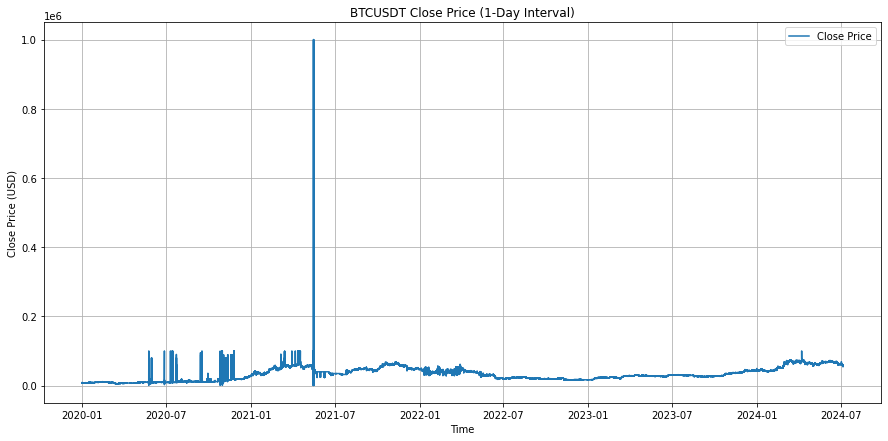

In [49]:
# Plot the 'Close' price over time
plt.figure(figsize=(15, 7))
plt.plot(BTCUSDT_Filtered_data_1M['Close'], label='Close Price')
plt.title('BTCUSDT Close Price (1-Day Interval)')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Now, Enough Plotting! On The Task!

## Generate Different Timeframe

### Converting 1 Minute Interval Data to 4 Hour Interval Data

In [22]:
BTCUSDT_Filtered_data_4H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '4H')
BTCUSDT_Filtered_data_4H

,Open,High,Low,Close,Volume
Open time (4H),,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729
...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692


## Performing Back Testing

### Using Signals Generated From MACD On 1 Year Data Of 4-Hour Time Interval

### Extracting 1 Year Data With 4 Hour Intervals

In [23]:
# Fetch 1 Year Data
BTCUSDT_Filtered_data_4H_Prev_1_Year = BTCUSDT_Filtered_data_4H.loc['2023-07-02' : '2024-07-02']
BTCUSDT_Filtered_data_4H_Prev_1_Year

,Open,High,Low,Close,Volume
Open time (4H),,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587
...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213


### Generating Signals Using MACD Indicator Function

In [52]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_4H_Prev_1_Year))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd

,Open,High,Low,Close,Volume,Signal
Open time (4H),,,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854,0
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079,-1
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358,-1
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029,-1
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587,-1
...,...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158,1
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912,1
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213,1


### Extracting 1 Year Data WIth 1 Minute Intervals & Generating Signals Using MACD Indicator Function

In [53]:
# Fetch 1 Year Data
BTCUSDT_Filtered_data_1M_Prev_1_Year = BTCUSDT_Filtered_data_1M.loc['2023-07-02' : '2024-07-02']
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_1M_Prev_1_Year))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd = BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd

,Open,High,Low,Close,Volume,Signal
Open time (1M),,,,,,
2023-07-02 00:00:00,30598.0,30598.0,30430.1,30550.0,134.917,0
2023-07-02 00:01:00,30476.7,30598.0,30476.6,30476.6,35.196,-1
2023-07-02 00:02:00,30500.0,30598.0,30476.6,30598.0,45.206,1
2023-07-02 00:03:00,30598.0,30598.0,30519.7,30598.0,67.580,1
2023-07-02 00:04:00,30598.0,30598.0,30524.0,30598.0,45.927,1
...,...,...,...,...,...,...
2024-07-02 23:55:00,63111.0,63211.0,62846.0,63062.6,24.091,-1
2024-07-02 23:56:00,63111.0,63161.0,63065.3,63065.3,0.400,-1
2024-07-02 23:57:00,63065.3,63065.4,63011.0,63011.0,3.875,-1


### Using Efficient Backtesting Function 1

In [42]:
backtest_df_func1 = generate_backtest_df_1(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd, BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd)
backtest_df_func1

,Open time (4H),direction,entry price,close price,action,PNL
0,2023-07-02 04:00:00,short,30679.9,0.0,None,NaN
1,2023-07-03 20:00:00,short,30679.9,30490.0,direction,0.618972
2,2023-07-03 20:00:00,long,30490.0,0.0,None,NaN
3,2023-07-05 12:00:00,long,30490.0,30820.0,direction,1.082322
4,2023-07-05 12:00:00,short,30820.0,0.0,None,NaN
...,...,...,...,...,...,...
415,2024-06-27 04:00:00,long,61418.2,61786.6,direction,0.599822
416,2024-06-27 04:00:00,short,61786.6,0.0,None,NaN
417,2024-06-27 16:00:00,short,61786.6,61415.4,direction,0.600778
418,2024-06-27 16:00:00,long,61415.4,0.0,None,NaN


### Using Efficient Backtesting Function 2

In [43]:
backtest_df_func2 = generate_backtest_df_2(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd, BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd)
backtest_df_func2

,Open time (4H),direction,entry price,close price,action,PNL
0,2023-07-02 04:00:00,short,30679.9,0.0,None,NaN
1,2023-07-03 20:00:00,short,30679.9,30490.0,direction,0.618972
2,2023-07-03 20:00:00,long,30490.0,0.0,None,NaN
3,2023-07-05 12:00:00,long,30490.0,30820.0,direction,1.082322
4,2023-07-05 12:00:00,short,30820.0,0.0,None,NaN
...,...,...,...,...,...,...
415,2024-06-27 04:00:00,long,61418.2,61786.6,direction,0.599822
416,2024-06-27 04:00:00,short,61786.6,0.0,None,NaN
417,2024-06-27 16:00:00,short,61786.6,61415.4,direction,0.600778
418,2024-06-27 16:00:00,long,61415.4,0.0,None,NaN


### Displaying Cumulative Profit & Loss (PNL)

In [73]:
print('Cumulative PNL Using Efficient Function 1: ', backtest_df_func1.PNL.sum())
print('Cumulative PNL Using Efficient Function 2: ', backtest_df_func2.PNL.sum())

Cumulative PNL Using Efficient Function 1:  272.19588895895936
Cumulative PNL Using Efficient Function 2:  272.19588895895936


## Backtesting On Different Technical Indicators

### Generate Signals Using RSI

In [56]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_4H_Prev_1_Year))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_rsi

,Open,High,Low,Close,Volume,RSI,Signal
Open time (4H),,,,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854,100.000000,-1
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079,0.000000,1
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358,0.000000,1
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029,19.175131,0
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587,17.192044,0
...,...,...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158,54.425955,0
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912,54.052249,0
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213,52.283431,0


### Generate Signals Using Stochastic RSI

In [57]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_4H_Prev_1_Year), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_stochrsi

,Open,High,Low,Close,Volume,StochRSI,StochRSI_K,StochRSI_D,Signal
Open time (4H),,,,,,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854,0.000000,0.000000,0.000000,0
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079,0.000000,0.000000,0.000000,0
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358,0.000000,0.000000,0.000000,0
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029,0.000000,0.000000,0.000000,0
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158,0.514532,65.698557,78.692974,0
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912,0.502651,57.621044,68.400138,0
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213,0.446414,48.786559,57.368720,0


### Generate Signals Using ADX With PSAR

In [58]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_4H_Prev_1_Year))
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_adx_and_sar

,Open,High,Low,Close,Volume,ADX,DI+,DI-,Parabolic_SAR,Signal
Open time (4H),,,,,,,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854,0.000000,0.000000,0.000000,30679.900000,0
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079,0.000000,0.000000,0.000000,30432.100000,0
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358,0.000000,0.000000,0.000000,30700.000000,0
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029,0.000000,0.000000,0.000000,30700.000000,0
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587,0.000000,0.000000,0.000000,30689.202000,0
...,...,...,...,...,...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158,36.646465,26.938784,5.363067,62750.000000,1
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912,38.799864,25.830747,5.142476,69407.000000,-1
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213,39.583177,24.222796,8.124677,69279.472000,-1


### Generate Signals Using OBV

In [59]:
# Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H_Prev_1_Year))
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_obv

,Open,High,Low,Close,Volume,OBV,Signal
Open time (4H),,,,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854,0.000000,0
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079,-63.147079,-1
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358,-129.416438,-1
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029,-59.467408,1
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587,-130.521996,-1
...,...,...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158,4988.882235,-1
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912,4984.376323,-1
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213,4976.995110,-1


### Generate Signals Using Bollinger Bands

In [60]:
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_bollinger = calculate_bollinger_bands_and_generate_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H_Prev_1_Year))
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_bollinger

,Open,High,Low,Close,Volume,MA20,Upper_band,Lower_band,Signal
Open time (4H),,,,,,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854,NaN,NaN,NaN,0
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079,NaN,NaN,NaN,0
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358,NaN,NaN,NaN,0
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029,NaN,NaN,NaN,0
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158,62141.825,64497.159581,59786.490419,0
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912,62216.855,64588.424787,59845.285213,0
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213,62292.630,64638.976395,59946.283605,0


## Performing Backtesting On Different Technical Indicators

### Applying Backtesting On RSI

In [62]:
backtest_df_rsi = generate_backtest_df_1(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_rsi, BTCUSDT_Filtered_data_1M_Prev_1_Year)
backtest_df_rsi

,Open time (4H),direction,entry price,close price,action,PNL
0,2023-07-02 04:00:00,long,30679.9,0.0,None,NaN
1,2023-07-02 12:00:00,long,30679.9,30379.4,direction,-0.979469
2,2023-07-02 12:00:00,short,30379.4,0.0,None,NaN
3,2023-07-14 00:28:00,short,30379.4,31450.0,sl,-3.524099
4,2023-10-24 04:00:00,short,32527.3,0.0,None,NaN
5,2023-10-24 07:14:00,short,32527.3,33640.2,sl,-3.421434
6,2023-10-24 08:00:00,short,34591.2,0.0,None,NaN
7,2023-11-02 05:25:00,short,34591.2,35668.7,sl,-3.114954
8,2023-12-04 12:00:00,short,41468.5,0.0,None,NaN
9,2023-12-04 16:00:00,short,41468.5,41827.3,direction,-0.865235


### Displaying Cumulative Profit & Loss (PNL)

In [63]:
backtest_df_rsi.PNL.sum()

-14.949135030743818

### Applying Backtesting On ADX With PSAR

In [65]:
backtest_df_adx_psar = generate_backtest_df_1(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_adx_and_sar, BTCUSDT_Filtered_data_1M_Prev_1_Year)
backtest_df_adx_psar

,Open time (4H),direction,entry price,close price,action,PNL
0,2023-07-12 08:00:00,long,30794.0,0.0,None,NaN
1,2023-07-14 16:00:00,long,30794.0,31168.3,direction,1.215497
2,2023-07-14 16:00:00,short,31168.3,0.0,None,NaN
3,2023-07-15 16:00:00,short,31168.3,30382.6,direction,2.520830
4,2023-07-15 16:00:00,short,30382.6,0.0,None,NaN
...,...,...,...,...,...,...
347,2024-07-01 00:00:00,short,61891.6,61706.5,direction,0.299071
348,2024-07-01 00:00:00,long,61706.5,0.0,None,NaN
349,2024-07-01 19:43:00,long,61706.5,64945.0,tp,5.248232
350,2024-07-02 08:00:00,short,63343.3,0.0,None,NaN


### Displaying Cumulative Profit & Loss (PNL)

In [66]:
backtest_df_adx_psar.PNL.sum()

96.81979464980745

### Applying Backtesting On OBV

In [67]:
backtest_df_obv = generate_backtest_df_1(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_obv, BTCUSDT_Filtered_data_1M_Prev_1_Year)
backtest_df_obv

,Open time (4H),direction,entry price,close price,action,PNL
0,2023-07-02 04:00:00,short,30679.9,0.0,None,NaN
1,2023-07-02 12:00:00,short,30679.9,30379.4,direction,0.979469
2,2023-07-02 12:00:00,long,30379.4,0.0,None,NaN
3,2023-07-02 16:00:00,long,30379.4,30379.3,direction,-0.000329
4,2023-07-02 16:00:00,short,30379.3,0.0,None,NaN
...,...,...,...,...,...,...
2529,2024-07-02 16:00:00,short,65217.4,62826.0,direction,3.666813
2530,2024-07-02 16:00:00,short,62826.0,0.0,None,NaN
2531,2024-07-02 20:00:00,short,62826.0,62793.6,direction,0.051571
2532,2024-07-02 20:00:00,long,62793.6,0.0,None,NaN


### Displaying Cumulative Profit & Loss (PNL)

In [68]:
backtest_df_obv.PNL.sum()

1296.5456618678315

### Applying Backtesting On Stochastic RSI

In [69]:
backtest_df_stochrsi = generate_backtest_df_1(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_stochrsi, BTCUSDT_Filtered_data_1M_Prev_1_Year)
backtest_df_stochrsi

,Open time (4H),direction,entry price,close price,action,PNL
0,2023-07-04 04:00:00,long,30898.9,0.0,None,NaN
1,2023-07-04 08:00:00,long,30898.9,30816.7,direction,-0.266029
2,2023-07-04 08:00:00,short,30816.7,0.0,None,NaN
3,2023-07-05 00:00:00,short,30816.7,30846.2,direction,-0.095727
4,2023-07-05 00:00:00,short,30846.2,0.0,None,NaN
...,...,...,...,...,...,...
1639,2024-07-01 10:33:00,short,61070.2,62999.2,sl,-3.158660
1640,2024-07-01 20:00:00,short,65217.4,0.0,None,NaN
1641,2024-07-02 00:00:00,short,65217.4,64160.9,direction,1.619966
1642,2024-07-02 00:00:00,short,64160.9,0.0,None,NaN


### Displaying Cumulative Profit & Loss (PNL)

In [70]:
backtest_df_stochrsi.PNL.sum()

289.1653108543897

### Applying Backtesting On Bollinger Bands

In [71]:
backtest_df_bollinger = generate_backtest_df_1(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_bollinger, BTCUSDT_Filtered_data_1M_Prev_1_Year)
backtest_df_bollinger

,Open time (4H),direction,entry price,close price,action,PNL
0,2023-07-12 04:00:00,short,30550.0,0.0,None,NaN
1,2023-07-12 08:00:00,short,30550.0,30794.0,direction,-0.798691
2,2023-07-12 08:00:00,short,30794.0,0.0,None,NaN
3,2023-07-14 00:00:00,short,30794.0,30809.6,direction,-0.050659
4,2023-07-14 00:00:00,short,30809.6,0.0,None,NaN
...,...,...,...,...,...,...
527,2024-06-30 20:39:00,short,60500.0,62430.0,sl,-3.190083
528,2024-07-01 04:00:00,short,61685.6,0.0,None,NaN
529,2024-07-01 19:42:00,short,61685.6,64403.5,sl,-4.406053
530,2024-07-01 20:00:00,short,65217.4,0.0,None,NaN


### Displaying Cumulative Profit & Loss (PNL)

In [72]:
backtest_df_bollinger.PNL.sum()

-294.32924628380596

## Findings In Backtesting
### Below Are The Cumulative Profit & Loss (PNL) For All Indicators
- **OBV** = 1294.447
- **StochRSI** = 287.034
- **MACD** = 272.196
- **ADX and SAR** = 95.952
- **RSI** = -14.949
- **Bollinger** = -296.426

# ***More Later!***